# How to use VoronoiBoost

In [85]:
import io
import json
import random

import folium
import matplotlib.cm as cm
import matplotlib.colors as colrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import MultiPolygon, Point, Polygon, mapping
from shapely.geometry import shape as Shape

from pyproj import Transformer
from shapely.ops import transform as shapely_transform
from PIL import Image

from voronoiBoost import VoronoiBoost

In [5]:
lambert93 = 'epsg:2154' # France metric system
wgs = 'epsg:4326'

transform_wgs_to_lambert93 = Transformer.from_crs(wgs, lambert93).transform
transform_lambert93_to_wgs = Transformer.from_crs(lambert93, wgs).transform

## Load data

### Load Orange BS deployment in Lyon

In [2]:
filename = 'data/df_bs_Orange_Lyon.pkl'
df_bs_sites = pd.read_pickle(filename)
df_bs_sites.head(2)

,id,_lon,_lat,operator,city,location,height,owner,postal_code,outdoor,x,y,lon,lat
3871,[53555],[5.076666667],[45.614444444],Orange,LYON,[Pylône autostable],[30],[TOTEM],[37110],[True],6.365906e+06,3.196582e+06,5.076667,45.614444
3872,[102526],[4.857777778],[45.77],Orange,LYON,[Pylône autostable],[30],[TDF],[37110],[True],6.400263e+06,3.181612e+06,4.857778,45.770000


In [3]:
lats, lons = list(df_bs_sites['lat']), list(df_bs_sites['lon'])
sites = list(zip(lats, lons))

### Load cities shapes

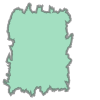

In [8]:
# load city shape from geojson file
city_file = 'data/Lyon.geojson'
fd = open(city_file, 'r')
city_json = json.load(fd)
fd.close()

# transform to shapely polygon
city_json = city_json['features'][0]['geometry']
city_shape = Shape(city_json)
city_shape = shapely_transform(lambda x, y: (y, x), city_shape)

## Run VoronoiBoost

In [10]:
model_path = 'model/voronoiBoost.sav.xz'
voronoiBoost = VoronoiBoost(sites, city_shape, model_path)

df_bs = voronoiBoost.compute_voronoiBoost()
df_bs.head(2)

Computing VoronoiBoost 🤓...
Computing Voronoi Tessellation 💻...
Voronoi Tessellation successful 🤩.
Computing Delaunay Graph 💻...
Delaunay Graph computed 🤩.
Computing features 🤖...
Features computed 🤓.
Loading model 📦...
Predicting 🤖...
Correcting scales ➕...
Scales corrected ✅.
Computing Voronois overlap 🤓...
Voronois overlap computed ✅.
VoronoiBoost computed ✅.


,id,lat,lon,voronoi,voronoi_boost
0,0,45.614444,5.076667,"POLYGON ((45.62979440759234 5.080906563299801,...",[(POLYGON ((45.62726881471814 5.07882661008250...
1,1,45.770000,4.857778,"POLYGON ((45.76829415953014 4.85527421704934, ...",[(POLYGON ((45.76822010796738 4.85515761787057...


## Show results

### Computing color map

In [95]:
values = []

# random sample for estimate min and max values for color scale
for bs in df_bs.sample(frac=.2, random_state=42).to_dict(orient='records'):
    lat, lon = bs['lat'], bs['lon']
    voronois_scaled_overlap = bs['voronoi_boost']
            
    for index, (voronoi_scaled_overlap, tau) in enumerate(voronois_scaled_overlap[::-1]):

        voronoi_scaled_overlap_area = shapely_transform(transform_wgs_to_lambert93, voronoi_scaled_overlap).area

        if index != len(voronois_scaled_overlap)-1:
            voronoi_scaled_overlap_inside, tau_inside = voronois_scaled_overlap[::-1][index+1]
            voronoi_scaled_overlap_inside_area = shapely_transform(transform_wgs_to_lambert93, voronoi_scaled_overlap_inside).area
            area = voronoi_scaled_overlap_area - voronoi_scaled_overlap_inside_area
            area = area/(100**2)
            tau_diff = tau - tau_inside
            density = tau_diff/area
            values.append(density)
        else:
            area = voronoi_scaled_overlap_area/(100**2)
            density = tau/area
            values.append(density)

vmin_value = min(values)
vmax_value = max(values)            
my_cmap = plt.cm.get_cmap('Greens')
norm = colrs.LogNorm(vmin=vmin_value,  vmax=vmax_value)

### Show Voronoi tessellation without probability

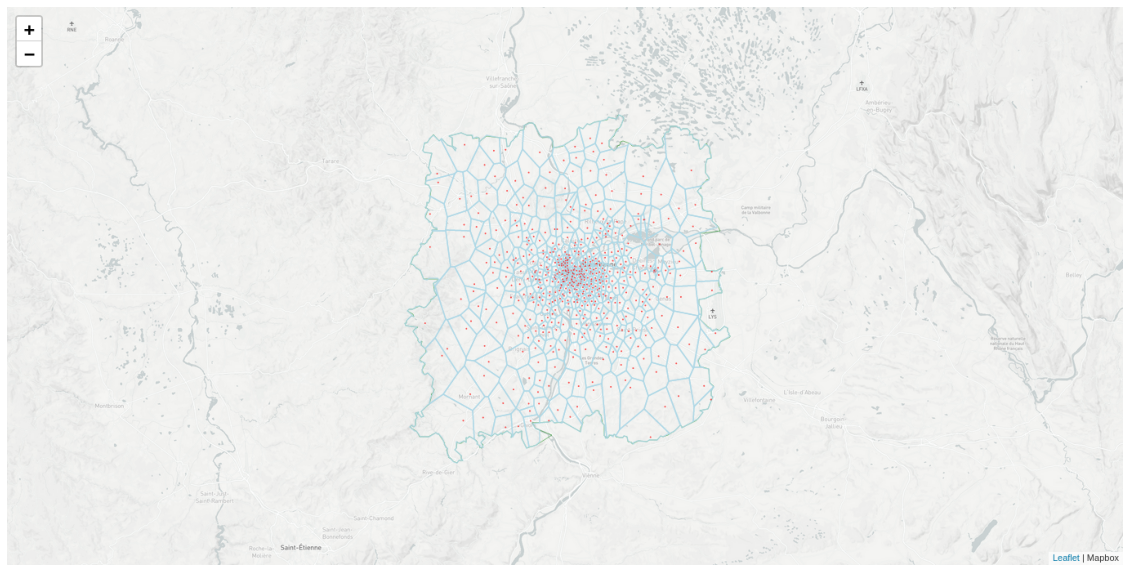

In [93]:
lat, lon = city_shape.centroid.x, city_shape.centroid.y

m = folium.Map(location=[lat, lon], zoom_control=True, zoom_start=10, 
                    tiles='https://api.mapbox.com/styles/v1/mapbox/light-v9/tiles/{z}/{x}/{y}?access_token=pk.eyJ1IjoibGFuZHlzIiwiYSI6ImNraHFjeXA1NzA1ZzkycW11cjl3dnpyMnAifQ.7mSkfJjaSfJXoGBxa_rg1g', attr='Mapbox')

folium.Polygon(mapping(city_shape)['coordinates'][0],
        color='green',
        opacity = .5,
        fill_opacity = 0,
        weight=1,
    ).add_to(m)

for bs in df_bs.to_dict(orient='records'):
    bs_id = bs['id']
    lat, lon = bs['lat'], bs['lon']
    voronoi = bs['voronoi']

    folium.Polygon(mapping(voronoi)['coordinates'][0],
        color='lightblue',
        opacity = .8,
        fill_opacity = 0,
        weight=1.5,
        ).add_to(m)

    folium.Circle(
        radius=5,
        location=[lat, lon],
        fill_color='red',
        fill_opacity=.7,
        opacity=0,
        tooltip=f'BS {bs_id}',
        popup=f'<input type=text value="{lat},{lon}">',
    ).add_to(m)

# Show map as Image (just for github)
img_data = m._to_png(3)
img = Image.open(io.BytesIO(img_data))

plt.figure(figsize=(20, 15))
plt.imshow(img)
plt.axis('off')
plt.show()

# Show map as HTML (for local use)
# m

### Show Voronoi tessallation with probability

In [51]:
lat, lon = city_shape.centroid.x, city_shape.centroid.y

m = folium.Map(location=[lat, lon], zoom_control=True, zoom_start=10, 
                    tiles='https://api.mapbox.com/styles/v1/mapbox/light-v9/tiles/{z}/{x}/{y}?access_token=pk.eyJ1IjoibGFuZHlzIiwiYSI6ImNraHFjeXA1NzA1ZzkycW11cjl3dnpyMnAifQ.7mSkfJjaSfJXoGBxa_rg1g', attr='Mapbox')

folium.Polygon(mapping(city_shape)['coordinates'][0],
        color='green',
        opacity = .5,
        fill_opacity = 0,
        weight=1,
    ).add_to(m)

for bs in df_bs.to_dict(orient='records'):
    bs_id = bs['id']
    lat, lon = bs['lat'], bs['lon']
    voronoi = bs['voronoi']

    voronoi_area = shapely_transform(transform_wgs_to_lambert93, voronoi).area
    area = voronoi_area/(100**2)
    tau = 0.999
    density = tau/area
    color = colrs.to_hex(my_cmap(norm(density)))

    folium.Polygon(mapping(voronoi)['coordinates'][0],
        color=color,
        fill_color=color,
        opacity = 0,
        fill_opacity = .3,
        weight=1.5,
        ).add_to(m)

    folium.Circle(
        radius=5,
        location=[lat, lon],
        fill_color='red',
        fill_opacity=.2,
        opacity=0,
        tooltip=f'BS {bs_id}',
        popup=f'<input type=text value="{lat},{lon}">',
    ).add_to(m)

# Show map as Image (just for github)
img_data = m._to_png(3)
img = Image.open(io.BytesIO(img_data))

plt.figure(figsize=(20, 15))
plt.imshow(img)
plt.axis('off')
plt.show()

# Show map as HTML (for local use)
# m

### Show VoronoiBoost 

In [96]:
# For illustration purposes, we will show just a few BSs
voronoiboost_bs_ids = [74, 95, 481, 111, 311, 314, 422]

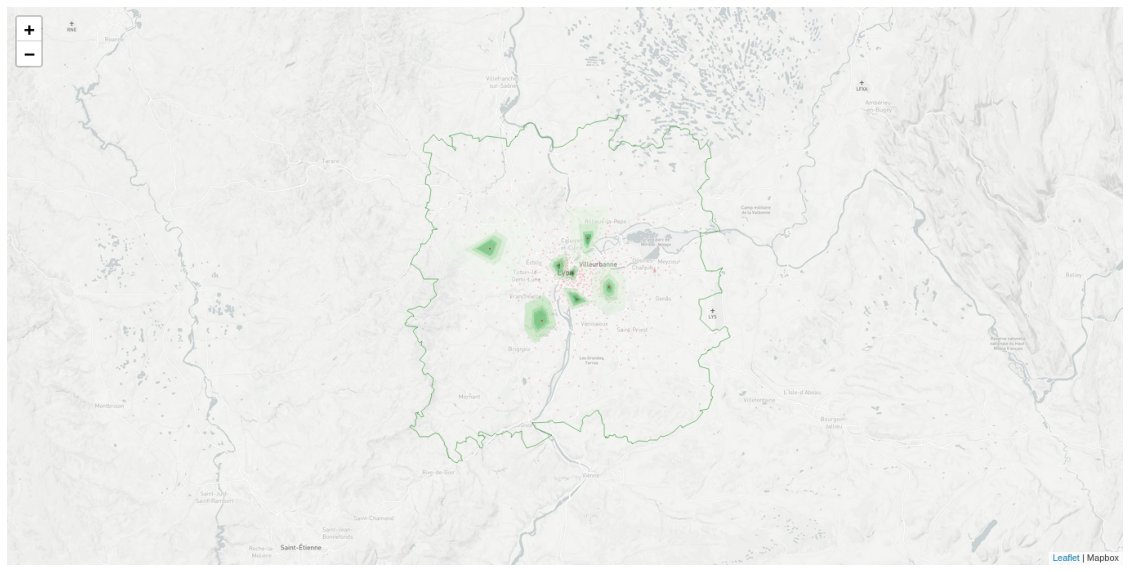

In [97]:
lat, lon = city_shape.centroid.x, city_shape.centroid.y

m = folium.Map(location=[lat, lon], zoom_control=True, zoom_start=10, 
                    tiles='https://api.mapbox.com/styles/v1/mapbox/light-v9/tiles/{z}/{x}/{y}?access_token=pk.eyJ1IjoibGFuZHlzIiwiYSI6ImNraHFjeXA1NzA1ZzkycW11cjl3dnpyMnAifQ.7mSkfJjaSfJXoGBxa_rg1g', attr='Mapbox')

folium.Polygon(mapping(city_shape)['coordinates'][0],
        color='green',
        opacity = .5,
        fill_opacity = 0,
        weight=1,
    ).add_to(m)
    
# show all BSs
for bs in df_bs.to_dict(orient='records'):
    bs_id = bs['id']
    lat, lon = bs['lat'], bs['lon']
    
    folium.Circle(
        radius=5,
        location=[lat, lon],
        fill_color='red',
        fill_opacity=.2,
        opacity=0,
        tooltip=f'BS {bs_id}',
        popup=f'<input type=text value="{lat},{lon}">',
    ).add_to(m)



# show voronoi boost BSs
for bs_id_index, bs_id in enumerate(voronoiboost_bs_ids):
    bs = df_bs[df_bs['id'] == bs_id].iloc[0]
    lat, lon = bs['lat'], bs['lon']
    # voronoi = bs['voronoi']
    voronois_scaled_overlap = bs['voronoi_boost']


    for index, (voronoi_scaled_overlap, tau) in enumerate(voronois_scaled_overlap[::-1]):
        
        voronoi_scaled_overlap_area = shapely_transform(transform_wgs_to_lambert93, voronoi_scaled_overlap).area
        area = voronoi_scaled_overlap_area/(100**2)
        density = tau/area
        
        if index != len(voronois_scaled_overlap)-1:
            voronoi_scaled_overlap_inside, tau_inside = voronois_scaled_overlap[::-1][index+1]
            voronoi_scaled_overlap_inside_area = shapely_transform(transform_wgs_to_lambert93, voronoi_scaled_overlap_inside).area
            area = voronoi_scaled_overlap_area - voronoi_scaled_overlap_inside_area
            area = area/(100**2)
            tau_diff = tau - tau_inside
            density = tau_diff/area

        color = colrs.to_hex(my_cmap(norm(density)))

        folium.Polygon(mapping(voronoi_scaled_overlap)['coordinates'][0],
            color=color,
            fill_color=color,
            opacity = 0,
            fill_opacity = .3,
            weight=1.5,
        ).add_to(m)


    folium.Circle(
        radius=40,
        location=[lat, lon],
        fill_color='red',
        fill_opacity=.7,
        opacity=0,
        tooltip=f'BS {bs_id}',
        popup=f'<input type=text value="{lat},{lon}">',
    ).add_to(m)

# Show map as Image (just for github)
img_data = m._to_png(3)
img = Image.open(io.BytesIO(img_data))

plt.figure(figsize=(20, 15))
plt.imshow(img)
plt.axis('off')
plt.show()

# Show map as HTML (for local use)
# m